In [143]:
#Import the necessary library

#dataset processing
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #data visualization, supporting matplotlib and pandas

#neural network 
import cv2 #library for computer vision
import imutils #image processing function, supporting cv2
from PIL import Image #image processing
import tensorflow as tf #deep neural networks
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras as K

import keras #interface for artificial neural networks
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras import layers
from keras.utils.vis_utils import plot_model

#model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve



In [144]:
#Dataset source: https://www.kaggle.com/ahmedhamada0/brain-tumor-detection
#Understanding the data
os.listdir('BrainTumor_dataset');
#include brain that has tumor and brain that does not

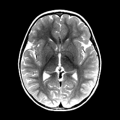

In [145]:
#Image of non-tumor
nonTumor=Image.open('BrainTumor_dataset/no/no0.jpg').resize((120,120))
nonTumor

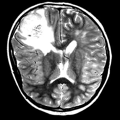

In [146]:
#Image of tumor
tumor=Image.open('BrainTumor_dataset/yes/y0.jpg').resize((120,120))
tumor


In [147]:
#set the directory 
yes=os.listdir('BrainTumor_dataset/yes')
no=os.listdir('BrainTumor_dataset/no')

#merge two data
data=np.concatenate([yes,no])

#map: yes to 1 and no to 0
x=np.full(len(yes), 1)
y=np.full(len(no), 0)
dataMapped= np.concatenate([x,y]) #used be used for testing and predicting later on
print(len(x), len(y))

1500 1500


In [148]:
#Data Augmentation (increase the amount of data by adding slightly modified copies of already existing data --> regularize and reduce overfitting)
'''
def dataAugment(fileDir, numSample, saveDir):
    #ImageDataGenerator generates new images with some modifications
    dataGenerate =ImageDataGenerator(rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2, brightness_range=(0.3,1.0), horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    for fileName in listdir(fileDir):
        image=cv2.imread(fileDir+'/'+fileName) #load an image from the specified file
        savePrefix= 'aug'+fileName[:-4]
        i=0
        for batch in dataGenerate.flow(x=image, batch_size=1, save_to_dir=saveDir, save_prefix=savePrefix,save_format='jpg'):
            i+=1
            if i> numSample:
                break
'''

"\ndef dataAugment(fileDir, numSample, saveDir):\n    #ImageDataGenerator generates new images with some modifications\n    dataGenerate =ImageDataGenerator(rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2, brightness_range=(0.3,1.0), horizontal_flip=True, vertical_flip=True, fill_mode='reflect')\n    for fileName in listdir(fileDir):\n        image=cv2.imread(fileDir+'/'+fileName) #load an image from the specified file\n        savePrefix= 'aug'+fileName[:-4]\n        i=0\n        for batch in dataGenerate.flow(x=image, batch_size=1, save_to_dir=saveDir, save_prefix=savePrefix,save_format='jpg'):\n            i+=1\n            if i> numSample:\n                break\n"

In [149]:
#Data Preprocessing

X=[] #create an empty dataset of X

#Set height and width of the image
imgHeight=200
imgWidth=200
imageSize=[imgHeight, imgWidth]

#Read images from the given directory:
for file in yes:
    img=cv2.imread('BrainTumor_dataset/yes/'+file)
    if img is None:
        print("Wrong path")
    else:
        imgResized= cv2.resize(img, (imgHeight, imgWidth))
        (b,g,r)=cv2.split(imgResized)
        img=cv2.merge([r,g,b])
        X.append(img)

for file in no:
    img=cv2.imread('BrainTumor_dataset/no/'+file)
    if img is None:
        print("Wrong path")
    else:
        imgResized= cv2.resize(img, (imgHeight, imgWidth))
        (b,g,r)=cv2.split(imgResized)
        img=cv2.merge([r,g,b])
        X.append(img)

X=np.squeeze(X) #remove single-dimensional entries from the shape of X
print(X.shape)


(3000, 200, 200, 3)


In [150]:
#OpenCV: Computer Vision
#crop the brain out of the image
def imageCrop(imageName, addPixel=0):
    newSet=[] #create an empty list
    for img in imageName:
        #binarize the image
        grayScale=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #convert the image to gray space
        blurImage=cv2.GaussianBlur(grayScale, [5,5],0) #blur to reduce high frequency noise to make the contour detection process more accurate

        #threshold
        thresHold=cv2.threshold(blurImage, 50,255, cv2.THRESH_BINARY)[1] #threshold the image or change the pixels to make the image easier to analyze (binary: black and white)
        erode=cv2.erode(thresHold, None, iterations=1) #remove pixels of the boundaries of the brain
        dilate=cv2.dilate(erode, None, iterations=1) #add pixels to the boundaries of the brain (not the inverse of the erosion - produced different image)

        #find contours
        contours=cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #spot the line that goes across the boundary of the brain (white-colored against the black background)
        contours=imutils.grab_contours(contours) #remove false positives areas and noises
        c=max(contours, key=cv2.contourArea) #find the biggest area of the contours

        #find the outer coordinates (extreme points)
        left = tuple(c[c[:, :, 0].argmin()][0])
        right = tuple(c[c[:, :, 0].argmax()][0])
        top = tuple(c[c[:, :, 1].argmin()][0])
        bottom = tuple(c[c[:, :, 1].argmax()][0])

        imgCropped=img[top[1]-addPixel:bottom[1]+addPixel, left[0]-addPixel:right[0]+addPixel] #crop the picture and modify the pixel according to the function parameter
        imgCropped=cv2.resize(imgCropped, (imgHeight, imgWidth)) #resize the picture
        newSet.append(imgCropped) #add the cropped image to the list

    return np.array(newSet)

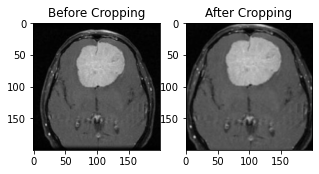

In [151]:
#apply crop function to all images
Xcropped= imageCrop(X)

#compare before cropping and after cropping
plt.figure(figsize=(5,5))

#before cropping
plt.subplot(121)
plt.imshow(X[10])
plt.title('Before Cropping')

#after cropping
plt.subplot(122)
plt.imshow(Xcropped[10])
plt.title('After Cropping')

plt.show()



In [152]:
def preprocessData(x,y):
    x=K.applications.resnet50.preprocess_input(x)
    y=K.utils.to_categorical(y,10)
    return x,y

In [153]:
#ImageDataGenerator generates new images with some modifications
dataGenerate =ImageDataGenerator(rescale=1./255.,validation_split=0.15)
#Normalize and split the data into training, testing, and validating datasets
from sklearn.model_selection import train_test_split
x=Xcropped
x=x.astype('float32')
y=np.asarray(dataMapped).astype('float32').reshape(-1,1)
x/=255
x_train, x_test_val, y_train, y_test_val=train_test_split(x, y, random_state=50, test_size=0.3, stratify=dataMapped)
x_test, x_val, y_test, y_val=train_test_split(x_test_val, y_test_val, test_size=0.5)
print(x_train.shape, y_train.shape)

x_train, y_train=preprocessData(x_train,y_train)
x_test,y_test=preprocessData(x_test,y_test)
print(x_train.shape,y_train.shape)


(2100, 200, 200, 3) (2100, 1)
(2100, 200, 200, 3) (2100, 10)


In [154]:
#Data Augmentation (increase the amount of data by adding slightly modified copies of already existing data --> regularize and reduce overfitting)
#ImageDataGenerator generates new images with some modifications
dataGenerate =ImageDataGenerator(rescale=1./255.,validation_split=0.15)

trainGenerator=dataGenerate.flow(x_train, y_train, batch_size = 20 ,shuffle=True)
testGenerator=dataGenerate.flow(x_test, y_test, batch_size = 20 ,shuffle=True)
valGenerator=dataGenerate.flow(x_val, y_val, batch_size = 20 ,shuffle=True)

#testGenerator=dataGenerate.flow_from_dataframe(dataframe=x_test, directory='./BrainTumor_dataset/', x_col='image_path',y_col='mask', subset='testing',batch_size=20,shuffle=True, class_mode="categorical",target_size=(imgHeight,imgWidth))
#valGenerator=dataGenerate.flow_from_dataframe(dataframe=x_val, directory='./BrainTumor_dataset/', x_col='image_path',y_col='mask', subset='validation',batch_size=20,shuffle=True, class_mode="categorical",target_size=(imgHeight,imgWidth))


In [155]:
#Convolutional Neural Network (Possible AlexNet or Inception(GoogLeNet) or ResNet-50)
#decide to use Resnet-50 (Deep Learning)
base=ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(200,200,3)))
base.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [156]:
#free the model weights (keep the weights constant so that they will not be updated --> avoid destroying any info during training)
for layer in base.layers:
    layer.trainable=False

In [157]:
head=K.models.Sequential()
head.add(base)
'''
head=Flatten(name='flatten')(head)
head=Dense(256, activation="relu")(head)
head=Dropout(0.3)(head)
head=Dense(256, activation="relu")(head)
head=Dropout(0.3)(head)
head=Dense(2,activation='softmax')(head)

model=Model(inputs=base.input, outputs=head)
'''
head.add(K.layers.Flatten())
head.add(K.layers.BatchNormalization())
head.add(K.layers.Dense(256, activation='relu'))
head.add(K.layers.Dropout(0.5))
head.add(K.layers.BatchNormalization())
head.add(K.layers.Dense(128, activation='relu'))
head.add(K.layers.Dropout(0.5))
head.add(K.layers.BatchNormalization())
head.add(K.layers.Dense(64, activation='relu'))
head.add(K.layers.Dropout(0.5))
head.add(K.layers.BatchNormalization())
head.add(K.layers.Dense(10, activation='softmax'))
head.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [158]:
#compile the model
head.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [159]:
#use early stopping to exit training
earlyStopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)

#save the model with least validation loss
checkPoint=ModelCheckpoint(filepath="cifar10.h5", monitor="val_acc", model='max', save_best_only=True)

In [160]:
#train the model
ResnetHistory=head.fit(x_train, y_train, batch_size=32, epochs=20,validation_split=0.15, callbacks=[checkPoint, earlyStopping], verbose=1)


Epoch 1/20
56/56 [==============================] - 133s 2s/step - loss: 2.5960 - accuracy: 0.1871 - val_loss: 2.0576 - val_accuracy: 0.5238
Epoch 2/20
56/56 [==============================] - 123s 2s/step - loss: 2.0167 - accuracy: 0.3681 - val_loss: 1.5601 - val_accuracy: 0.5429
Epoch 3/20
56/56 [==============================] - 123s 2s/step - loss: 1.5237 - accuracy: 0.5490 - val_loss: 1.1695 - val_accuracy: 0.6063
Epoch 4/20
56/56 [==============================] - 162s 3s/step - loss: 1.1248 - accuracy: 0.6263 - val_loss: 0.8530 - val_accuracy: 0.6857
Epoch 5/20
56/56 [==============================] - 180s 3s/step - loss: 0.8657 - accuracy: 0.7120 - val_loss: 0.6360 - val_accuracy: 0.7683
Epoch 6/20
56/56 [==============================] - 202s 4s/step - loss: 0.6727 - accuracy: 0.7552 - val_loss: 0.5426 - val_accuracy: 0.7746
Epoch 7/20
56/56 [==============================] - 214s 4s/step - loss: 0.5651 - accuracy: 0.7776 - val_loss: 0.4920 - val_accuracy: 0.8127
Epoch 8/20
56

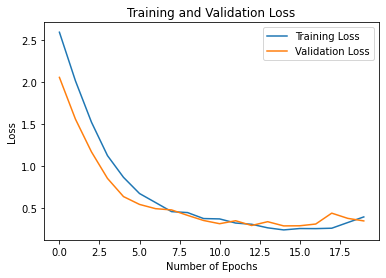

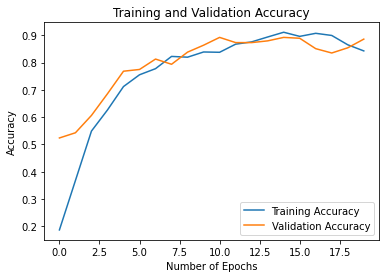

In [162]:
#Model Evaluation
history = ResnetHistory.history

trainLoss= history['loss']
valLoss = history['val_loss']
trainAcc = history['accuracy']
valAcc = history['val_accuracy']

# Loss
plt.figure()
plt.plot(trainLoss, label='Training Loss')
plt.plot(valLoss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
    
# Accuracy#
plt.figure()
plt.plot(trainAcc, label='Training Accuracy')
plt.plot(valAcc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [163]:
# Evaluate the model on test set
score=head.evaluate(x_test,y_test, batch_size=128, verbose=1)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])

4/4 [==============================] - 20s 5s/step - loss: 0.3699 - accuracy: 0.8422

 Test accuracy: 0.8422222137451172


In [200]:
#make the prediction
prediction=head.predict(x_test)
y_pred = np.array(prediction>=0.5).astype('int')

In [208]:

#metrics calculation

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='micro')
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_test, y_pred, average='micro')
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

# specificity calculation
tn, fp, fn, tp = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)).ravel()
specificity = tn / (tn+fp)
print('Specificity: ',specificity)


Accuracy: 0.840000
Precision: 0.841871
Recall: 0.840000
F1 score: 0.840934
ROC AUC: 0.911235
[[199  21]
 [ 50 180]]
Specificity:  0.9045454545454545


<AxesSubplot:>

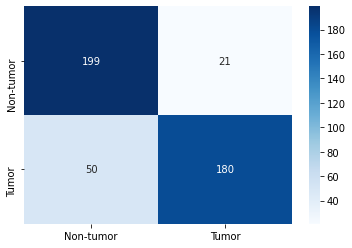

In [209]:
# plot confusion matrix
categories = ['Non-tumor', 'Tumor']
df_matrix = pd.DataFrame(matrix, index = categories, columns = categories)
sns.heatmap(df_matrix, annot=True, cmap='Blues', fmt='d')

In [222]:
#Use VGG-19 (the only downside is this model has a lot of parameters ~~138milions)
# VGG19 model is pre-trained with imagenet data 
vgg = VGG19(input_shape=imageSize + [3], weights='imagenet', include_top=False)

NUM_CLASSES = 1

# vgg19 + dropout + flatten + dropout + dense

vgg19 = Sequential()
vgg19.add(vgg)
vgg19.add(layers.Dropout(0.3))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(NUM_CLASSES, activation='relu')) #relu is the most common activator function

# make the layers untrainable so the layers are not updated during the training process
for layer in vgg19.layers:
    layer.trainable=False

vgg19.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 dropout_20 (Dropout)        (None, 6, 6, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_21 (Dropout)        (None, 18432)             0         
                                                                 
 dense_26 (Dense)            (None, 1)                 18433     
                                                                 
Total params: 20,042,817
Trainable params: 0
Non-trainable params: 20,042,817
_________________________________________________________________


In [223]:
# defining cost function and optimization method
#compile the model using Adam function as the optimizer
vgg19.compile(loss='binary_crossentropy', optimizer='adam', metrics=["acc"])

In [224]:
#checkpoint which stores the weights of the model when maximum validation accuracy is found
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="weights.best.hdf5",save_weights_only=True,monitor='val_acc',mode='max',save_best_only=True)

VGGHistory = vgg19.fit(x_train, y_train, batch_size = 20, epochs = 60, validation_split = 0.15, callbacks=[checkpoint])

Epoch 1/60
90/90 [==============================] - 207s 2s/step - loss: 2.8854 - acc: 0.7776 - val_loss: 1.5425 - val_acc: 0.9000
Epoch 2/60
90/90 [==============================] - 228s 3s/step - loss: 2.7975 - acc: 0.7826 - val_loss: 1.5425 - val_acc: 0.9000
Epoch 3/60
90/90 [==============================] - 213s 2s/step - loss: 3.0285 - acc: 0.7552 - val_loss: 1.5425 - val_acc: 0.9000
Epoch 4/60
90/90 [==============================] - 199s 2s/step - loss: 2.9389 - acc: 0.7741 - val_loss: 1.5425 - val_acc: 0.9000
Epoch 5/60
90/90 [==============================] - 205s 2s/step - loss: 2.9142 - acc: 0.7785 - val_loss: 1.5425 - val_acc: 0.9000
Epoch 6/60
90/90 [==============================] - 210s 2s/step - loss: 2.9627 - acc: 0.7763 - val_loss: 1.5425 - val_acc: 0.9000
Epoch 7/60
 4/90 [>.............................] - ETA: 2:47 - loss: 3.0437 - acc: 0.7600

In [ ]:
#make the prediction
prediction=vgg19.predict(x_test)
y_pred = np.array(prediction>=0.5).astype('int')

In [ ]:
#Model Evaluation
history = VGGHistory.history

trainLoss= history['loss']
valLoss = history['val_loss']
trainAcc = history['acc']
valAcc = history['val_acc']

# Loss
plt.figure()
plt.plot(trainLoss, label='Training Loss')
plt.plot(valLoss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
    
# Accuracy#
plt.figure()
plt.plot(trainAcc, label='Training Accuracy')
plt.plot(valAcc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on test set
score = vgg19.evaluate(x_test, y_test, batch_size=128 verbose=1) 

# Print test accuracy
print('\n', 'Test accuracy:', score[1])

In [ ]:

#metrics calculation

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='micro')
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_test, y_pred, average='micro')
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

# specificity calculation
tn, fp, fn, tp = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)).ravel()
specificity = tn / (tn+fp)
print('Specificity: ',specificity)


In [ ]:
# plot confusion matrix
categories = ['Non-tumor', 'Tumor']
df_matrix = pd.DataFrame(matrix, index = categories, columns = categories)
sns.heatmap(df_matrix, annot=True, cmap='Blues', fmt='d')


In [ ]:
#index 0 = No , index 1 = Yes
labels = ["No", "Yes"]

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
  ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  # Display each image
  ax.imshow(np.squeeze(x_test[index]))
  predict_index = y_pred[index]
  true_index = y_test[index]
  # Set the title for each image
  ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()
